# PDE-FIND for Burger's Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on Burger's equation with an added diffusive term.
$$
u_t + uu_x = u_{xx}
$$
The solution given is a single travelling wave, starting out as a Gaussian.

In [1]:
import sys
sys.path.append("./")

In [14]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from PDE_FIND import build_linear_system, print_pde
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


In [8]:
data = sio.loadmat('../data/burgers.mat')
u = real(data['usol'])
x = real(data['x'][0])
t = real(data['t'][:,0])
dt = t[1]-t[0]
dx = x[2]-x[1]

Text(0.5, 0, 't')

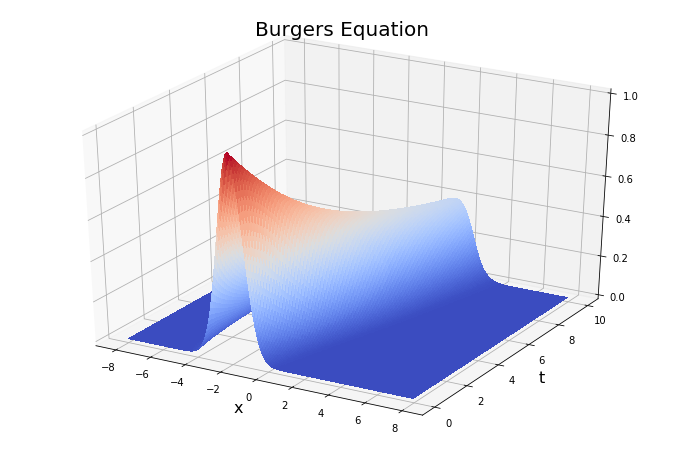

In [9]:
X, T = np.meshgrid(x, t)
fig1 = figure()
ax = fig1.gca(projection='3d')
surf = ax.plot_surface(X, T, u.T, rstride=1, cstride=1, cmap=cm.coolwarm,
    linewidth=0, antialiased=False)
title('Burgers Equation', fontsize = 20)
xlabel('x', fontsize = 16)
ylabel('t', fontsize = 16)

In [10]:
u.shape

(256, 101)

## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [11]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
['1'] + rhs_des[1:]

['1',
 'u',
 'u^2',
 'u^3',
 'u_{x}',
 'uu_{x}',
 'u^2u_{x}',
 'u^3u_{x}',
 'u_{xx}',
 'uu_{xx}',
 'u^2u_{xx}',
 'u^3u_{xx}',
 'u_{xxx}',
 'uu_{xxx}',
 'u^2u_{xxx}',
 'u^3u_{xxx}']

In [55]:
def TrainSTRidge(R, Ut, lam, d_tol, maxit = 100, STR_iters = 10, l0_penalty = None, normalize = 2, split = 0.8, print_best_tol = False):
    """
    This function trains a predictor using STRidge.

    It runs over different values of tolerance and trains predictors on a training set, then evaluates them 
    using a loss function on a holdout set.

    Please note published article has typo.  Loss function used here for model selection evaluates fidelity using 2-norm,
    not squared 2-norm.
    """

    # Split data into 80% training and 20% test, then search for the best tolderance.
    np.random.seed(0) # for consistancy
    n,_ = R.shape
    train = np.random.choice(n, int(n*split), replace = False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train,:]
    TestR = R[test,:]
    TrainY = Ut[train,:]
    TestY = Ut[test,:]
    D = TrainR.shape[1]       

    # Set up the initial tolerance and l0 penalty
    d_tol = float(d_tol)
    tol = d_tol
    if l0_penalty == None: l0_penalty = 0.001*np.linalg.cond(R)

    # Get the standard least squares estimator
    w = np.zeros((D,1))
    w_best = np.linalg.lstsq(TrainR, TrainY)[0]
    err_best = np.linalg.norm(TestY - TestR.dot(w_best), 2) + l0_penalty*np.count_nonzero(w_best)
    tol_best = 0

    # Now increase tolerance until test performance decreases
    for iter in range(maxit):

        # Get a set of coefficients and error
        print ('iter', iter)
        print ("==============tol=====================", tol)
        w = STRidge(R,Ut,lam,STR_iters,tol,normalize = normalize)
        err = np.linalg.norm(TestY - TestR.dot(w), 2) + l0_penalty*np.count_nonzero(w)
        print ()
        # Has the accuracy improved?
        if err <= err_best:
            err_best = err
            w_best = w
            tol_best = tol
            tol = tol + d_tol

        else:
            tol = max([0,tol - 2*d_tol])
            d_tol  = 2*d_tol / (maxit - iter)
            print ("debug tol d_tol", tol, d_tol)
            tol = tol + d_tol

    if print_best_tol: print ("Optimal tolerance:", tol_best)

    return w_best

def STRidge(X0, y, lam, maxit, tol, normalize = 2, print_results = False):
    """
    Sequential Threshold Ridge Regression algorithm for finding (hopefully) sparse 
    approximation to X^{-1}y.  The idea is that this may do better with correlated observables.

    This assumes y is only one column
    """

    n,d = X0.shape
    X = np.zeros((n,d), dtype=np.complex64)
    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d,1))
        for i in range(0,d):
            Mreg[i] = 1.0/(np.linalg.norm(X0[:,i],normalize))
            X[:,i] = Mreg[i]*X0[:,i]
    else: X = X0
    
    # Get the standard ridge esitmate
    if lam != 0: w = np.linalg.lstsq(X.T.dot(X) + lam*np.eye(d),X.T.dot(y))[0]
    else: w = np.linalg.lstsq(X,y)[0]
    num_relevant = d
    biginds = np.where( abs(w) > tol)[0]
    
    # Threshold and continue
    for j in range(maxit):
        # Figure out which items to cut out
        smallinds = np.where( abs(w) < tol)[0]
        new_biginds = [i for i in range(d) if i not in smallinds]
        # If nothing changes then stop
        if num_relevant == len(new_biginds): break
        else: num_relevant = len(new_biginds)
            
        # Also make sure we didn't just lose all the coefficients
        if len(new_biginds) == 0:
            if j == 0: 
                #if print_results: print "Tolerance too high - all coefficients set below tolerance"
                return w
            else: break
        biginds = new_biginds
        
        # Otherwise get a new guess
        w[smallinds] = 0
        if lam != 0: w[biginds] = np.linalg.lstsq(X[:, biginds].T.dot(X[:, biginds]) + lam*np.eye(len(biginds)),X[:, biginds].T.dot(y))[0]
        else: w[biginds] = np.linalg.lstsq(X[:, biginds],y)[0]

    # Now that we have the sparsity pattern, use standard least squares to get w
    if biginds != []: w[biginds] = np.linalg.lstsq(X[:, biginds],y)[0]
    
    if normalize != 0: return np.multiply(Mreg,w)
    else: return w


## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [56]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,100.)
print ("PDE derived using STRidge")
print_pde(w, rhs_des)

/home/ning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/ning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/ning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise t

iter 0
==============tol===================== 100.0

debug tol d_tol 0 2.0
iter 1
==============tol===================== 2.0

iter 2
==============tol===================== 4.0

iter 3
==============tol===================== 6.0

debug tol d_tol 2.0 0.041237113402061855
iter 4
==============tol===================== 2.0412371134020617

iter 5
==============tol===================== 2.0824742268041234

iter 6
==============tol===================== 2.123711340206185

iter 7
==============tol===================== 2.164948453608247

iter 8
==============tol===================== 2.2061855670103085

iter 9
==============tol===================== 2.2474226804123703

iter 10
==============tol===================== 2.288659793814432

iter 11
==============tol===================== 2.3298969072164937

iter 12
==============tol===================== 2.3711340206185554

iter 13
==============tol===================== 2.412371134020617

iter 14
==============tol===================== 2.453608247422679

iter 

In [45]:
w.shape

(16, 1)

In [46]:
err = abs(np.array([(1 -  1.000987)*100, (.1 - 0.100220)*100/0.1]))
print ("Error using PDE-FIND to identify Burger's equation:\n")
print ("Mean parameter error:", mean(err), '%')
print ("Standard deviation of parameter error:", std(err), '%')

Error using PDE-FIND to identify Burger's equation:

Mean parameter error: 0.15935000000000255 %
Standard deviation of parameter error: 0.06064999999999543 %


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [11]:
numpy.random.seed(0)
un = u + 0.01*std(u)*np.random.randn(u.shape[0],u.shape[1])

In [12]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)

In [13]:
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print ("PDE derived using STRidge")
print_pde(w, rhs_des)

PDE derived using STRidge
u_t = (-1.009655 +0.000000i)uu_{x}
    + (0.102966 +0.000000i)u_{xx}
   


In [14]:
err = abs(np.array([(1 -  1.009655)*100, (.1 - 0.102966)*100/0.1]))
print ("Error using PDE-FIND to identify Burger's equation with added noise:\n")
print ("Mean parameter error:", mean(err), '%')
print ("Standard deviation of parameter error:", std(err), '%')

Error using PDE-FIND to identify Burger's equation with added noise:

Mean parameter error: 1.9657499999999966 %
Standard deviation of parameter error: 1.0002499999999996 %
